In [1]:
'''
baseline version that is basically without using a graph
see how much can be pushed to the LLM

working
work through the testing code

to do
TEST prompt
TEST simple graph
TEST gradio interface
    look over old notes
TEST evaluate
    better testing questions
    https://docs.smith.langchain.com/evaluation
        do a simple POC and make sure it logs to langsmith




backlog
    other ntoes have more backlog items


'''

'\nbaseline version that is basically without using a graph\nsee how much can be pushed to the LLM\n\nworking\nwork through the testing code\n\nto do\nTEST prompt\nTEST simple graph\nTEST gradio interface\n    look over old notes\nTEST evaluate\n    better testing questions\n    https://docs.smith.langchain.com/evaluation\n        do a simple POC and make sure it logs to langsmith\n\n\n\n\nbacklog\n    other ntoes have more backlog items\n\n\n'

### Constants

In [2]:
import gradio as gr
import getpass
import os

from IPython.display import Image, display

from langchain_openai import OpenAI, ChatOpenAI

#from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

from pydantic import BaseModel, Field

from typing import Annotated, Literal, Optional

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages

from langchain_core.tools import tool

from typing import Literal

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

import pgeocode

import uuid

c:\Users\james\github_repos\untitled_09_2024_repo\sep2024\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("LANGSMITH_API_KEY")
# _set_env("TAVILY_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "EV Prototype v0.4"


In [4]:
testing_questions_list = [
    'What is the cost of owning a 2024 new Chevy Blazer EV compared to the cost of owning a new 2024 Ford Edge?',

]

In [5]:
def display_graph(graph):
    try:
        display(Image(graph.get_graph().draw_mermaid_png()))
    except Exception:
        # This requires some extra dependencies and is optional
        pass


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

### v 0.01 Minimal LLM based

In [6]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str

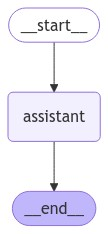

In [7]:
class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


llm = ChatOpenAI(model_name="gpt-3.5-turbo")


ev_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an assistant that helps gather information for people who want to estimate the cost of a car over 5 years. "
            "Find the cost of the following: \n"
            "- purchasing the car. \n"
            "- any rebates the care may be eligible if it is an electric or hybrid car. \n"
            "- registration fees and taxes by year. \n"
            "- fuel cost. Electric if electric or hybrid car or fuel cost if gas car. \n"
            "- maintenance cost. \n"
            "Use general estimates if the user does not provide detailed information. "
            "If the user provides detailed information such as location, insurance quote, used or new car, than use that information. \n"
        
            "Answer in the format of: \n"
            "- vehicle: initial_cost \n"
            "- Add a table in the format of the vehicle and cost after each year. \n"
            "- Add a table in the format of the vehicle and the total cost of each major expense. \n"

            "If the user asks for information on multiple cars, provide that information in an easily comparible way. \n"

            "Example: \n"
            "I live in New Hampshire and want to know the cost of owning a 2024 new Chevy Blazer EV versus a 2024 Ford Edge. \n"
            "Answer: \n"
            "New 2024 Chevy Blazer MSRP: $44,600. $37,100 after federal EV rebate \n"
            "Total Cost after 5 years: \n"
            "New 2024 Ford Edge MSRP: $38,465 \n"
            "Total Cost after 5 years: \n"
            "Year   |   Chevy Blazer Total Cost |   Ford Edge Total Cost \n"
            "Year 1 | 37,600                    |   39,000\n"
            "Year 2 | 38,600                    |   41,000\n"
            "Year 3 | 39,600                    |   43,000\n"
            "Year 4 | 40,600                    |   45,000\n"
            "Year 5 | 41,600                    |   47,000\n"
            "Total Cost of Major Expenses: \n"
            "Item       |   Chevy Blazer   |   Ford Edge \n"
            "Fuel       |   1,000          |   1,200\n"
            "Maintenance|   2,000          |   2,500\n"
            "Registration|  500            |   600\n"
            "Insurance  |   1,000          |   1,200\n"
        ),
        ("placeholder", "{messages}"),
    ]
)

ev_assistant_runnable = ev_prompt | llm

builder = StateGraph(State)

builder.add_node("assistant", Assistant(ev_assistant_runnable))
# builder.set_entry_point("assistant")
builder.add_edge(START, "assistant")
builder.add_edge("assistant", END)

memory = MemorySaver()
baseline_agent_graph = builder.compile(
    checkpointer=memory,
)

display_graph(baseline_agent_graph)

In [8]:
thread_id = str(uuid.uuid4())

config = {
    "configurable": {

        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

_printed = set()
for question in testing_questions_list:
    events = baseline_agent_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)


================================ Human Message =================================

What is the cost of owning a 2024 new Chevy Blazer EV compared to the cost of owning a new 2024 Ford Edge?
================================== Ai Message ==================================

To estimate the cost of owning a 2024 new Chevy Blazer EV compared to a new 2024 Ford Edge, we will consider several factors including purchasing cost, potential rebates, registration fees and taxes, fuel cost, and maintenance cost. 

Let's start by gathering some information:
- MSRP of the 2024 Chevy Blazer EV
- MSRP of the 2024 Ford Edge
- Any potential rebates for the Chevy Blazer EV
- Location for estimating registration fees and taxes
- Estimated fuel cost per year
- Estimated maintenance cost per year

Once we have this information, we can proceed with the cost estimation for both vehicles. Feel free to provide any additional details you may have to get a more accurate estimation.


### Gradio Interface

In [9]:
def generate_chat_response(user_input: str):
    '''

    the invoking function calls the graph
            
    Parameters
    ----------

    Returns
    -------
    chat_response: str
        Response from the chat agent
    
    '''

    chat_response = "Error"
    
    config = {"configurable": {"thread_id": "1"}}

    events = baseline_agent_graph.stream(
        {"messages": ("user", user_input)}, config, #stream_mode="values"
    )
    for event in events:

        for key, value in event.items():
            chat_response = value

    return chat_response

In [10]:

# Create the Gradio interface
with gr.Blocks() as interface:
    gr.Markdown("## Compare costs of using cars.")
    prompt_input = gr.Textbox(label="Prompt")

    # Button to submit the prompt and get the output
    generate_button = gr.Button("Generate")

    # Textbox to display the LLM's chat response
    chat_response_box = gr.Textbox(label="Chat Response", lines=4)

    # Link the components together
    generate_button.click(fn=generate_chat_response, inputs=prompt_input, outputs=[chat_response_box])

In [11]:
# Launch the interface
interface.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


### Eval and Test case

In [ ]:
# # create a data set
# # https://docs.smith.langchain.com/evaluation/how_to_guides/datasets/manage_datasets_programmatically
# from langsmith import Client

# example_inputs = [
# ("What is the five year cost of a new 2024 Toyata Prius?", '''
# To provide an accurate five-year cost estimate for a 2024 Toyota Prius, I'll break down the key expenses:

# Purchase Price


# Base model starts around $27,950-$32,000
# Mid-range models: $33,000-$38,000
# Higher trim levels can reach $40,000+


# Fuel Costs


# Estimated annual mileage: 12,000 miles
# Prius hybrid gets approximately 56 mpg combined
# Average gas price: ~$3.50/gallon
# Estimated annual fuel cost: $750-$900
# 5-year fuel cost: ~$3,750-$4,500


# Maintenance


# Toyota recommends service every 5,000-10,000 miles
# Estimated annual maintenance: $300-$500
# 5-year maintenance cost: ~$1,500-$2,500


# Insurance


# Average annual insurance: $1,400-$2,000
# 5-year insurance cost: $7,000-$10,000


# Depreciation


# Estimated 40-50 percent depreciation over 5 years
# Potential value loss: $12,000-$19,000

# Estimated Total 5-Year Cost: $52,200-$65,000
# These are rough estimates and can vary based on location, driving habits, and specific model chosen.

# '''),
# ]

# client = Client()
# dataset_name = "Basic vehicle questions asdf"

# # Storing inputs in a dataset lets us
# # run chains and LLMs over a shared set of examples.
# dataset = client.create_dataset(
#   dataset_name=dataset_name, description="Questions and answers about vehicle costs.",
# )

# # Prepare inputs, outputs, and metadata for bulk creation
# inputs = [{"question": input_prompt} for input_prompt, _ in example_inputs]
# outputs = [{"answer": output_answer} for _, output_answer in example_inputs]
# metadata = [{"source": "working example"} for _ in example_inputs]

# # client.create_examples(
# #   inputs=inputs,
# #   outputs=outputs,
# #   metadata=metadata,
# #   dataset_id=dataset.id,
# # )

In [ ]:
# from langsmith import evaluate, Client

# client = Client()
# dataset = client.clone_public_dataset(
#     "https://smith.langchain.com/public/a63525f9-bdf2-4512-83e3-077dc9417f96/d"
# )

In [12]:
# from langsmith import evaluate, Client

# client = Client()
# dataset = client.clone_public_dataset(
#     "https://smith.langchain.com/public/a63525f9-bdf2-4512-83e3-077dc9417f96/d"
# )

# # 2. Define an evaluator
# def is_error_message(outputs: dict, reference_outputs: dict) -> bool:
#     if str(outputs["answer"]).lower() == "error":
#         return True
#     return False
#     #return len(outputs["answer"]) < (3 * len(reference_outputs["answer"]))

# # # 2. Define an evaluator
# # def is_concise(outputs: dict, reference_outputs: dict) -> bool:
# #     return len(outputs["answer"]) < (3 * len(reference_outputs["answer"]))

# # # 3. Define the interface to your app
# # def chatbot(inputs: dict) -> dict:

# #     generate_chat_response
# #     return {"answer": inputs["question"] + " is a good question. I don't know the answer."}

# def generate_chatbot(inputs: dict) -> dict:
#     '''

#     the invoking function calls the graph
            
#     Parameters
#     ----------

#     Returns
#     -------
#     chat_response: str
#         Response from the chat agent
    
#     '''

#     chat_response = "Error"
    
#     config = {"configurable": {"thread_id": "1"}}

#     events = baseline_agent_graph.stream(
#         {"messages": ("user", inputs["question"])}, config, #stream_mode="values"
#     )
#     for event in events:

#         for key, value in event.items():
#             chat_response = value

#     return {"answer": chat_response}

# # 4. Run an evaluation
# evaluate(
#     generate_chatbot,
#     data=dataset,
#     evaluators=[is_error_message],
#     experiment_prefix="basic prototype eval"
# )

In [13]:
from langsmith import evaluate, Client

# 1. Create and/or select your dataset
client = Client()
dataset = client.clone_public_dataset(
    "https://smith.langchain.com/public/a63525f9-bdf2-4512-83e3-077dc9417f96/d"
)

# 2. Define an evaluator
def is_concise(outputs: dict, reference_outputs: dict) -> bool:
    return len(outputs["answer"]) < (3 * len(reference_outputs["answer"]))

# 3. Define the interface to your app
def chatbot(inputs: dict) -> dict:
    return {"answer": inputs["question"] + " is a good question. I don't know the answer."}

# 4. Run an evaluation
evaluate(
    chatbot,
    data=dataset,
    evaluators=[is_concise],
    experiment_prefix="my first experiment "
)

View the evaluation results for experiment: 'my first experiment -e7ccb6d5' at:
https://smith.langchain.com/o/4d4a1df9-252f-54f7-a27f-550564db7e86/datasets/21480c06-434a-40db-a3dc-388fef467aeb/compare?selectedSessions=a765e970-0473-40e8-a668-3280aa9dcc42




2it [00:00, 15.98it/s]


,inputs.question,outputs.answer,error,reference.answer,feedback.is_concise,execution_time,example_id,id
0,What is the largest mammal?,What is the largest mammal? is a good question...,None,The blue whale,False,0.001001,9eebe78d-c8cf-4627-8257-4b3674ca7ec8,e9aafd4b-3270-4d7e-a5d7-5227f45a88cd
1,What do mammals and birds have in common?,What do mammals and birds have in common? is a...,None,They are both warm-blooded,False,0.000964,26d18d54-d22f-4dea-9f67-a5ad705f68f6,5df77df3-f34f-4db8-b10c-dc56c27acad9


In [14]:
def generate_chatbot(inputs: dict) -> dict:
    '''

    the invoking function calls the graph
            
    Parameters
    ----------

    Returns
    -------
    chat_response: str
        Response from the chat agent
    
    '''

    chat_response = "Error"
    
    config = {"configurable": {"thread_id": "1"}}

    events = baseline_agent_graph.stream(
        {"messages": ("user", inputs["question"])}, config, #stream_mode="values"
    )
    for event in events:

        for key, value in event.items():
            chat_response = value

    return {"answer": chat_response}

# 4. Run an evaluation
evaluate(
    #chatbot,
    generate_chatbot,
    data=dataset,
    evaluators=[is_concise],
    experiment_prefix="my first experiment "
)

View the evaluation results for experiment: 'my first experiment -09db0d50' at:
https://smith.langchain.com/o/4d4a1df9-252f-54f7-a27f-550564db7e86/datasets/21480c06-434a-40db-a3dc-388fef467aeb/compare?selectedSessions=78b58a99-1027-4699-bd14-99eeb28c0b16




2it [00:02,  1.07s/it]


,inputs.question,outputs.answer,error,reference.answer,feedback.is_concise,execution_time,example_id,id
0,What is the largest mammal?,{'messages': content='The largest mammal is th...,None,The blue whale,True,0.818212,9eebe78d-c8cf-4627-8257-4b3674ca7ec8,bf43ac28-d92d-4ba3-bdef-e729b8ab27b5
1,What do mammals and birds have in common?,{'messages': content='Mammals and birds share ...,None,They are both warm-blooded,True,1.990256,26d18d54-d22f-4dea-9f67-a5ad705f68f6,17be993a-7e59-47ae-b0e1-8897e6d8752d


AttributeError: 'Dataset' object has no attribute 'inputs'